# Part 3, Topic 3: DPA on Firmware Implementation of AES (HARDWARE)

---
**THIS IS NOT THE COMPLETE TUTORIAL - see file with `(MAIN)` in the name.**

---

First you'll need to select which hardware setup you have. You'll need to select a `SCOPETYPE`, a `PLATFORM`, and a `CRYPTO_TARGET`. `SCOPETYPE` can either be `'OPENADC'` for the CWLite/CW1200 or `'CWNANO'` for the CWNano. `PLATFORM` is the target device, with `'CWLITEARM'`/`'CW308_STM32F3'` being the best supported option, followed by `'CWLITEXMEGA'`/`'CW308_XMEGA'`, then by `'CWNANO'`. `CRYPTO_TARGET` selects the crypto implementation, with `'TINYAES128C'` working on all platforms. An alternative for `'CWLITEXMEGA'` targets is `'AVRCRYPTOLIB'`. For example:

```python
SCOPETYPE = 'OPENADC'
PLATFORM = 'CWLITEARM'
CRYPTO_TARGET='TINYAES128C'
SS_VER='SS_VER_1_1'
```

In [1]:
SCOPETYPE = 'OPENADC'
PLATFORM = 'CWNANO'
CRYPTO_TARGET='TINYAES128C'
SS_VER='SS_VER_1_1'

The following code will build the firmware for the target.

In [3]:
#import chipwhisperer as cw
#scope = cw.scope()

%run "../../Setup_Scripts/Setup_Generic.ipynb"

INFO: Found ChipWhisperer😍


In [4]:
%%bash -s "$PLATFORM" "$CRYPTO_TARGET" "$SS_VER"
cd ../../../hardware/victims/firmware/simpleserial-aes
make PLATFORM=$1 CRYPTO_TARGET=$2 SS_VER=$3

Building for platform CWNANO with CRYPTO_TARGET=TINYAES128C
SS_VER set to SS_VER_1_1
Blank crypto options, building for AES128
rm -f -- simpleserial-aes-CWNANO.hex
rm -f -- simpleserial-aes-CWNANO.eep
rm -f -- simpleserial-aes-CWNANO.cof
rm -f -- simpleserial-aes-CWNANO.elf
rm -f -- simpleserial-aes-CWNANO.map
rm -f -- simpleserial-aes-CWNANO.sym
rm -f -- simpleserial-aes-CWNANO.lss
rm -f -- objdir/*.o
rm -f -- objdir/*.lst
rm -f -- simpleserial-aes.s simpleserial.s stm32f0_hal_nano.s stm32f0_hal_lowlevel.s aes.s aes-independant.s
rm -f -- simpleserial-aes.d simpleserial.d stm32f0_hal_nano.d stm32f0_hal_lowlevel.d aes.d aes-independant.d
rm -f -- simpleserial-aes.i simpleserial.i stm32f0_hal_nano.i stm32f0_hal_lowlevel.i aes.i aes-independant.i
.
Welcome to another exciting ChipWhisperer target build!!
arm-none-eabi-gcc (15:9-2019-q4-0ubuntu1) 9.2.1 20191025 (release) [ARM/arm-9-branch revision 277599]
Copyright (C) 2019 Free Software Foundation, Inc.
This is free software; see the sou

Size after:
   text	   data	    bss	    dec	    hex	filename
   5636	    540	   1628	   7804	   1e7c	simpleserial-aes-CWNANO.elf
+--------------------------------------------------------
+ Default target does full rebuild each time.
+ Specify buildtarget == allquick == to avoid full rebuild
+--------------------------------------------------------
+--------------------------------------------------------
+ Built for platform CWNANO Built-in Target (STM32F030) with:
+ CRYPTO_TARGET = TINYAES128C
+ CRYPTO_OPTIONS = AES128C
+--------------------------------------------------------


In [5]:
cw.program_target(scope, prog, "../../../hardware/victims/firmware/simpleserial-aes/simpleserial-aes-{}.hex".format(PLATFORM))
print(target.read())

Detected known STMF32: STM32F04xxx
Extended erase (0x44), this can take ten seconds or more
Attempting to program 6175 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 6175 bytes
heXXX



For this tutorial, we'll need to capture around 2500 traces:

In [6]:
import tqdm 
#import tnrange
import numpy as np
import time

ktp = cw.ktp.Basic()
trace_array = []
textin_array = []
textout_array = []

key, text = ktp.next()

target.set_key(key)

scope.adc.samples = 3000

print(scope.adc.samples)

N = 3000
for i in range(N):
    print("+")
    scope.arm()
    
    target.simpleserial_write('p', text)
    
    ret = scope.capture()
    if ret:
        print("Target timed out!")
        continue
    
    response = target.simpleserial_read('r', 16)
    print("text", text)
    print("response", response)
    
    
    trace_array.append(scope.get_last_trace())
    textin_array.append(text)
    textout_array.append(response)
    
    key, text = ktp.next() 

3000
+
text CWbytearray(b'fc 92 ac 7f b4 f9 61 89 44 fb c5 e3 6b f3 df 99')
response CWbytearray(b'50 cf 80 35 a1 83 6e 08 59 a3 46 d7 89 bd 3d f0')
+
text CWbytearray(b'fb a4 d3 d8 4c a0 3e d6 ca 6e 84 cb aa ea 99 78')
response CWbytearray(b'b2 5e 37 be 68 fd 09 1f b4 d3 14 6f 49 06 70 1b')
+
text CWbytearray(b'81 e7 61 d3 91 02 e6 64 99 1f d1 42 c0 82 cb 18')
response CWbytearray(b'00 bd 73 85 a9 46 ba f3 0c dc c7 af a8 0d fb 23')
+
text CWbytearray(b'a3 ce 7b 14 9a 2f 82 b6 70 18 0d 1c 1a ab 36 1f')
response CWbytearray(b'd3 fd fa a8 a3 46 9d 54 82 e1 18 ac f5 fc 04 9c')
+
text CWbytearray(b'bf 13 10 1e 37 e4 1e c4 60 4d f2 ab 25 aa 5c 65')
response CWbytearray(b'f7 0d 78 5c c4 dd 35 2c 54 fa 39 e8 ba 6c 31 7e')
+
text CWbytearray(b'cc 6c 62 be 0f 41 c4 17 55 88 71 5e cc 7a f7 bf')
response CWbytearray(b'a8 a2 c2 12 72 4c 9a 25 79 e0 61 81 ba d7 ee 5a')
+
text CWbytearray(b'9f 90 ae 6e 89 0a 82 2a 46 d4 d2 21 a6 94 46 4e')
response CWbytearray(b'1b 7a 8b b3 03 08 5a aa f8 2d 87 3a 7

text CWbytearray(b'41 9e 1d f2 a1 20 5f 70 ce fe 7e 1b 05 32 fb cc')
response CWbytearray(b'c6 b1 9f 9d 3d 6c 6c 60 fb 49 30 74 1b e1 36 7d')
+
text CWbytearray(b'6f a7 44 86 9e 61 a1 17 28 45 37 e4 67 71 60 ff')
response CWbytearray(b'3f 4c 96 5b a6 51 57 09 8a 00 99 1c f0 08 a4 c9')
+
text CWbytearray(b'44 f9 d7 c4 91 ba 37 83 0e 06 35 a9 48 fc a2 a2')
response CWbytearray(b'b7 c0 28 ce 9d e6 83 01 8a 93 e7 d2 8d 88 cb 79')
+
text CWbytearray(b'b1 44 1c f9 e5 08 3d 70 59 a9 af 77 55 e8 46 43')
response CWbytearray(b'fe 50 d3 93 af e4 a2 f7 9d 75 cb 4a 1e 79 b1 57')
+
text CWbytearray(b'0c c4 15 fe af ca 78 2e 64 43 68 b2 15 00 a7 b4')
response CWbytearray(b'd6 6e 65 38 9c bd 94 89 9d 27 db 4c f2 6f f6 89')
+
text CWbytearray(b'c0 2f da 40 6b cd e2 4a 3a 56 b2 49 9a 5f 92 f3')
response CWbytearray(b'21 4c 43 f1 df a1 e2 b0 01 dc 2b 81 64 de d4 ac')
+
text CWbytearray(b'17 3b 76 ed ec dd 79 7d d6 0c c0 fb f9 4b fb 63')
response CWbytearray(b'cc 06 d2 1f 08 aa 94 f7 87 b7 13 eb 9c a7 d7

text CWbytearray(b'd6 6e f5 60 83 19 14 0c a6 23 7e a1 c2 3e bb 5b')
response CWbytearray(b'82 9f 78 ec 7b 2f d8 33 c4 df 7e ee b5 81 a9 07')
+
text CWbytearray(b'd3 f5 87 db e1 0b 1e 38 20 a8 de 4b f7 14 11 93')
response CWbytearray(b'fe a6 e2 06 85 cf 5f 68 03 2f ee 07 5a 86 20 fd')
+
text CWbytearray(b'51 05 89 b1 a8 1f 73 4e 1e 80 7b 0e d5 96 9f 2d')
response CWbytearray(b'f4 93 b2 f6 93 b8 66 2a 8c 82 3e 15 c3 41 51 a8')
+
text CWbytearray(b'f7 d4 18 0e 93 91 6d f5 be a8 93 d2 a6 f3 1e c6')
response CWbytearray(b'ce 1a fb 5f 78 24 86 6d 51 5e 7e ed 62 03 11 3a')
+
text CWbytearray(b'92 b0 81 26 18 06 8d a5 01 ff 12 a1 0b 1f d6 dc')
response CWbytearray(b'2b 01 17 4c e2 80 f3 1c e1 b8 3c 0d 89 47 af 31')
+
text CWbytearray(b'32 d4 4d f2 94 db b4 52 7c 73 56 1a 40 b7 95 40')
response CWbytearray(b'a9 e0 8e b2 5f 9a 8f 6c dd f7 e6 81 c8 cc d7 18')
+
text CWbytearray(b'1a d3 39 a1 71 0e 8f 71 75 37 88 b2 0f b5 66 88')
response CWbytearray(b'1e 0e 12 60 25 e1 cb 87 07 eb 72 86 fb 27 a7

text CWbytearray(b'67 a9 97 2f 19 ef 7a bb ed 97 18 d0 75 3a c7 aa')
response CWbytearray(b'39 29 ef f8 43 5c 21 34 bd 68 29 c8 ed 5e df 67')
+
text CWbytearray(b'ba 1c 35 99 0e 16 b5 2a c0 55 a6 dc e7 81 d6 61')
response CWbytearray(b'93 e8 64 d4 7d 01 e1 54 40 0f 67 c4 44 4b 68 e9')
+
text CWbytearray(b'6c a3 45 16 0d c1 ee e0 13 be 40 ed fc cb 89 91')
response CWbytearray(b'db 67 a8 1d 0a a0 32 8c 7f 29 2b 8c af 22 9e fe')
+
text CWbytearray(b'68 70 00 ee 2a 0d ca 6c fd f1 58 38 bb 7c 24 3e')
response CWbytearray(b'84 37 53 d4 88 21 16 f7 be 92 64 6a c6 40 96 a6')
+
text CWbytearray(b'f8 7e d5 97 ef 5e 0c 3d f8 ee 50 4e 4e e2 9e be')
response CWbytearray(b'1d 29 20 3c af 85 c3 48 18 bd 9a 3c 97 3e 37 0f')
+
text CWbytearray(b'fb 38 a4 0e f8 6a af 5c dd a7 a3 23 2d c5 7b 08')
response CWbytearray(b'd9 cb aa df bb 2c 9e 09 1d 9a db fc 41 d2 3b 95')
+
text CWbytearray(b'b1 a9 34 97 f3 60 da 36 27 58 ac 31 31 3b 70 2d')
response CWbytearray(b'ab 3b 18 c8 9f 06 2f 9d 7e be 90 36 84 a1 df

text CWbytearray(b'9b 0b d3 17 49 f6 fa 26 c0 1c c4 0c e3 eb 88 4e')
response CWbytearray(b'd9 5c ba 9a da 6d 93 87 48 a4 fa 29 ab 45 37 54')
+
text CWbytearray(b'f1 79 a6 27 cc f9 a6 6b 93 ab 9a 61 60 1e 94 47')
response CWbytearray(b'7e 67 a1 10 39 76 9c 1b 8d 61 50 0e 54 63 d0 e8')
+
text CWbytearray(b'9d 0b 8e db 6c ad 0b 6d 3c d3 42 be e6 3d fc d9')
response CWbytearray(b'e8 07 83 bc 5a ae 14 12 3d 7a e9 6d 71 54 e7 da')
+
text CWbytearray(b'ec e5 0b b5 64 40 af 5b 3d a7 94 b3 3b 4c 76 27')
response CWbytearray(b'd9 88 4e 6f 7d 34 f3 4a 90 be 52 6f da fc 70 6f')
+
text CWbytearray(b'd1 5e 51 e5 78 f3 24 ea e7 fc 94 9f ab f6 92 30')
response CWbytearray(b'1f a0 d9 57 c2 bc ff 42 98 cc 08 1e d0 eb 72 cd')
+
text CWbytearray(b'2b b3 6c 71 64 42 be e1 5a 22 17 bf 20 a5 87 c1')
response CWbytearray(b'90 4e 1a fd eb 63 e4 ee 51 90 6f 54 de 02 70 8f')
+
text CWbytearray(b'21 9e dc e9 32 f9 1b 43 83 7b 9f b0 c1 4e 4c f1')
response CWbytearray(b'ee f3 d7 1d f6 61 da fa fe d6 eb ba 8f 38 5c

text CWbytearray(b'bd c1 60 6c 23 3b 49 2e c0 f2 aa e4 dd 70 a7 6a')
response CWbytearray(b'91 84 ea 47 69 d5 b2 c6 26 1f 22 b4 b9 ae ad 6a')
+
text CWbytearray(b'94 f4 04 49 0a 85 30 23 7f d3 43 53 32 fd a9 88')
response CWbytearray(b'17 9c f6 52 8d dd 5f 91 5e da fa d4 83 ba b6 e4')
+
text CWbytearray(b'1a 53 06 f1 d7 b2 26 20 39 88 75 4e 0d 48 8a 3b')
response CWbytearray(b'c0 7c 22 69 22 87 a0 85 e8 92 26 5b bf 32 e5 e1')
+
text CWbytearray(b'a6 57 e5 0b d9 5d 3f 10 96 0c 98 cd b5 d9 1a dd')
response CWbytearray(b'f4 87 c9 35 85 52 34 7f 0a a0 29 a7 25 58 86 a5')
+
text CWbytearray(b'59 aa bf 3a eb 43 b4 2d ef c7 91 c2 56 f7 37 7a')
response CWbytearray(b'29 88 aa 4b 39 e2 f4 a8 e2 e9 7f 9f d2 ee fa 75')
+
text CWbytearray(b'23 b6 e9 ef 0f 26 36 80 12 67 a1 7c f8 ab ca f7')
response CWbytearray(b'aa 66 4b af a6 26 7c 93 6f 36 e2 07 c8 90 d4 df')
+
text CWbytearray(b'e6 b9 53 cd a3 d8 ef 99 23 d7 98 56 d0 08 e3 f2')
response CWbytearray(b'4f b6 6d c8 50 9a 1e f4 ec 3e 93 7a 54 d0 62

text CWbytearray(b'6c 35 4c d2 01 2e 64 0d 6c 57 e1 5c e6 9a 49 3c')
response CWbytearray(b'48 36 07 2c 13 60 8e 22 ba de 5e 3c 5e b0 c5 d7')
+
text CWbytearray(b'66 3c ee 85 09 48 b9 78 38 70 bf e5 2c d9 4b dd')
response CWbytearray(b'b1 fe 96 cf 4e c1 86 f5 22 d9 d9 9e 8c fe 8a 98')
+
text CWbytearray(b'9b 36 6b 52 cf e2 ae e2 09 22 7c e5 3c f1 6c f1')
response CWbytearray(b'64 d8 0e bb 19 5e 17 1b 88 24 85 19 a7 90 47 fb')
+
text CWbytearray(b'e2 a2 70 d9 70 f7 02 b9 06 02 c0 e4 eb 9b af 7c')
response CWbytearray(b'52 a5 5d 19 75 f5 ec 02 21 47 bf b8 88 66 d0 27')
+
text CWbytearray(b'c6 9a 6a e9 f2 09 b0 a5 4a 79 fe 6b 26 3d 52 09')
response CWbytearray(b'df 78 66 7d d5 e1 58 7a 85 0b 02 e1 17 92 08 17')
+
text CWbytearray(b'f2 aa 63 20 b8 20 ed fb 46 5a 7e f3 37 ab ef 0f')
response CWbytearray(b'85 c0 bd 34 6f a7 38 77 ba a4 77 dc 8a 55 ef f4')
+
text CWbytearray(b'a1 03 b2 60 26 a4 55 6c d3 d1 7d 57 8d 04 d8 89')
response CWbytearray(b'18 ce 4e d9 91 e2 d5 3e f8 98 a0 38 04 b9 72

text CWbytearray(b'8b 6c e7 21 23 ea 62 bb 97 ae 1a 4c 10 15 c3 73')
response CWbytearray(b'9b eb 3d fd 9b 7d 4b 77 37 0e 2d 28 33 0e 0e 55')
+
text CWbytearray(b'e0 b2 73 09 cb 86 fa 9a 62 45 7f 26 8d c1 bd fb')
response CWbytearray(b'd6 5c 7f c4 a6 b8 c8 9d a5 60 07 a7 3e 26 05 88')
+
text CWbytearray(b'6f 9f 8c 73 00 e2 c0 0d 45 67 1f 11 c4 4d 5d 49')
response CWbytearray(b'90 8b 7f 46 fa cd 5e a1 60 78 1c af 3a 42 5b 4c')
+
text CWbytearray(b'ac 6d 01 68 b5 ae 4b e4 de be f2 cd 52 89 99 85')
response CWbytearray(b'87 72 37 6a 35 5a d4 37 3d d2 41 90 bf a2 3f d3')
+
text CWbytearray(b'fc 88 62 5d 70 02 2f 60 1d 05 9d 1f 80 1b 72 ac')
response CWbytearray(b'9d 61 ee 71 5c 31 0d d3 44 82 c3 62 c7 9a 6b 64')
+
text CWbytearray(b'25 d2 09 5a d0 0b f5 56 a2 fa 96 de fb a2 1d 32')
response CWbytearray(b'ca 79 10 0c 46 6a ce 26 d4 bc 83 72 57 18 8d f8')
+
text CWbytearray(b'5d d0 d5 80 4d 64 f4 59 2c 96 ee 20 e5 17 2f 59')
response CWbytearray(b'09 1d 72 8f 6c ec 32 45 dd 26 23 98 cf ea 1b

text CWbytearray(b'2d 80 44 0c b7 19 aa f5 c7 05 a2 ef d6 e3 59 3a')
response CWbytearray(b'99 37 a5 e3 5e 9c 54 32 69 de 9e 39 79 ad 23 0c')
+
text CWbytearray(b'1f fc f0 2b db 5d 78 51 03 ed e8 5b f1 2a 36 8f')
response CWbytearray(b'37 59 83 4f 68 4b a9 b7 ab 3d 59 26 03 71 91 4f')
+
text CWbytearray(b'1b da c2 25 71 19 ac c3 ff a4 6f 94 75 29 2b 9d')
response CWbytearray(b'79 b2 d7 ab f3 5b 09 82 82 ba d1 90 80 4e 98 cc')
+
text CWbytearray(b'75 43 7d 46 c6 0a 21 5c 5d 60 1f 89 c7 16 0d 26')
response CWbytearray(b'e2 ae 05 a5 4b db c8 e0 76 08 df ab 1c dd f2 ba')
+
text CWbytearray(b'b1 c7 db 56 da 7a 9d 41 fd 6b db 44 99 14 d6 ba')
response CWbytearray(b'bd 54 af 82 82 f7 87 01 f4 ab 19 87 65 94 e6 c7')
+
text CWbytearray(b'50 9a fc 8c a7 c9 14 93 d9 f9 2b 99 ec 44 49 33')
response CWbytearray(b'd8 5c e4 b2 25 cd 36 20 02 58 ff d3 31 b5 b8 4d')
+
text CWbytearray(b'0c da 98 35 15 fa cf 25 19 66 40 f7 2d 21 b8 91')
response CWbytearray(b'f1 62 36 32 2f 4c 93 98 c9 11 8c 92 23 d8 b6

text CWbytearray(b'94 52 6b 10 25 16 72 59 20 a6 4c b6 e0 01 b9 4d')
response CWbytearray(b'6d 78 c2 14 8f 69 79 88 f0 0f 35 2e 3d 7a 09 2d')
+
text CWbytearray(b'58 e4 ec 17 dc a3 a0 de fb 3c 19 25 41 7c 3d 37')
response CWbytearray(b'14 7e 02 5f 10 19 13 16 a8 8a 14 8d ef 48 04 f3')
+
text CWbytearray(b'2b 29 ad 2e d7 9a d3 fc 8c 85 6d 3e 59 a6 53 c9')
response CWbytearray(b'55 ff e2 a8 60 d7 68 e4 37 7a 0d 35 fc 7b 78 b1')
+
text CWbytearray(b'37 d6 29 73 59 b3 52 69 6e 73 aa ea 9e 56 d4 2c')
response CWbytearray(b'99 58 fa e3 e1 dc 0d 60 1c ba 9c a4 f5 25 0a 15')
+
text CWbytearray(b'1f 94 54 3a 4e 7d 88 5f a5 e5 63 ff 3a 66 f5 70')
response CWbytearray(b'77 cf 87 cd 20 b5 96 71 bf b3 44 16 47 ba e9 ae')
+
text CWbytearray(b'd3 08 eb 8d 35 85 6c 01 ab 3f 73 6c da 76 59 30')
response CWbytearray(b'31 2d 7b 9e d0 85 29 a2 c0 47 c6 35 90 91 19 f4')
+
text CWbytearray(b'6a 19 38 f9 90 aa f2 69 14 d8 c0 c2 77 a3 95 88')
response CWbytearray(b'2f 4a 58 6b bf 82 17 f6 fe f5 a8 a9 d0 66 47

text CWbytearray(b'73 28 38 25 87 8d 02 c8 ca 8d 57 e5 dd fb 0f 0f')
response CWbytearray(b'9f 1e 1a 0f 59 9a 5c 51 b6 9c 73 c1 5e d5 c7 bb')
+
text CWbytearray(b'd1 74 b0 54 52 2c 75 6a 7e 62 e1 82 a5 1a 40 68')
response CWbytearray(b'40 b1 91 ea 44 9f e2 c4 d6 2c 77 86 25 0f d0 06')
+
text CWbytearray(b'13 44 f1 c9 06 9b 1d 46 3d cf 0e cf 2d be ba 43')
response CWbytearray(b'70 d3 ca b1 d0 b0 7a bf 64 6d 93 28 65 49 f4 64')
+
text CWbytearray(b'f9 e2 dd b3 ee a7 cd 5d 07 80 6a f7 e9 fb 57 13')
response CWbytearray(b'8c f8 c3 6b 75 d3 48 21 9d a8 70 1c b3 ec 86 1e')
+
text CWbytearray(b'67 b1 b5 35 b2 2d 28 3f a6 6a 46 b8 e4 09 41 22')
response CWbytearray(b'36 59 dc e8 2e 7e 2b 01 7f aa c1 e0 4d f6 d6 25')
+
text CWbytearray(b'cf e3 7e 65 0e 1a 28 6d 93 70 a7 1c 9a 56 99 26')
response CWbytearray(b'54 6b b8 18 9d 0e 96 0e a1 a4 e6 02 1a 9c cc a4')
+
text CWbytearray(b'09 e4 a2 b1 dd 92 b1 3f 5f 1f f3 e2 74 06 d6 81')
response CWbytearray(b'7d 5c 31 2d a0 28 89 b6 17 ce 72 7e 08 a0 09

text CWbytearray(b'd2 cc 5a e4 a3 98 ce fc f1 d4 ee 70 35 d5 5f f8')
response CWbytearray(b'18 84 af bd b1 33 2e 83 c9 5e ef fa 05 a9 02 56')
+
text CWbytearray(b'3f 5d b6 b8 70 c8 8e 03 47 20 ab c4 8f 51 77 0c')
response CWbytearray(b'cf 0e 5c 93 aa 5b 34 63 38 e0 44 b9 77 7b 43 c7')
+
text CWbytearray(b'55 de be b9 96 8f 01 4b 97 b9 6b 75 c1 26 97 5b')
response CWbytearray(b'2c 2a d7 af aa 12 39 90 fe 03 f2 80 30 e5 80 a1')
+
text CWbytearray(b'84 c6 67 30 87 e5 f5 aa b1 61 6c a0 bb 34 d4 07')
response CWbytearray(b'2e 41 98 f7 1e dc 2c 84 c8 09 07 76 59 a4 f7 97')
+
text CWbytearray(b'6c 52 6b 0a 2a 77 aa b1 e4 32 5e 62 a5 b9 5d ba')
response CWbytearray(b'21 bc 38 7d 99 e0 4a 15 00 b8 89 4b ae 41 fc cb')
+
text CWbytearray(b'd6 0d b2 cd d4 0c c9 a2 de e4 e9 5c 61 ab 70 3a')
response CWbytearray(b'43 18 55 ad 63 3a b0 32 4c 8f fe 0e 1a cd 6c f5')
+
text CWbytearray(b'aa 7d ca 1b ca 21 2a 07 ab 34 e1 51 92 99 7b b0')
response CWbytearray(b'cc 57 cc 11 d0 e5 dd 5e 2d a6 08 cf 10 99 79

text CWbytearray(b'e1 a5 fb 7d 78 cc 21 50 36 df 72 16 19 08 1a de')
response CWbytearray(b'43 50 23 ef 32 ca 0e 3d 37 ca 47 8f 42 b7 3c 85')
+
text CWbytearray(b'8b 90 84 a6 b5 2c 93 1d b4 f6 b0 3d d6 17 7f 01')
response CWbytearray(b'0d 77 8e 96 d4 0a 3b 9b 3a e4 2b 3c 0c 4b 32 31')
+
text CWbytearray(b'c4 5d df ae c4 a7 a5 11 1c 2e 06 c5 d4 2f 83 91')
response CWbytearray(b'a7 b7 cf 82 b8 18 4b dd a3 26 73 c6 ed f7 51 bc')
+
text CWbytearray(b'0f ad c8 b1 f3 32 ff a3 5d 4d a5 dc 53 7b b7 65')
response CWbytearray(b'87 47 1d 1e d6 96 48 4f 75 3b f9 08 1f 1a 4f 69')
+
text CWbytearray(b'fb a8 37 df 7f f2 be b0 2a cf 35 bc 88 e5 67 4c')
response CWbytearray(b'a6 c9 a5 e9 89 2b 08 57 52 c9 15 ae 65 81 11 6b')
+
text CWbytearray(b'f2 f9 03 58 d5 b7 96 ea c5 2d b6 ae c4 40 3a 79')
response CWbytearray(b'4f 8c 04 e0 7b f4 e2 83 59 81 0f 09 46 a2 24 6b')
+
text CWbytearray(b'76 4d 88 44 8d 64 0a 67 32 a6 c5 92 e6 db 5d 47')
response CWbytearray(b'56 f7 ed a5 bf 47 a1 94 ba 4e f4 f3 65 66 31

text CWbytearray(b'62 e5 8a 94 48 30 5a 9a c9 0b 20 fa a0 c1 28 67')
response CWbytearray(b'62 e3 9f 75 33 7d 14 bb 9a e7 57 7c 18 7e 4d bc')
+
text CWbytearray(b'df 2c a6 ac c6 f9 4d 6e 4c b2 d1 9d 15 02 56 eb')
response CWbytearray(b'ba 4a b9 36 cc 3d 99 d9 5c e4 f4 03 5a f0 3d a1')
+
text CWbytearray(b'28 f4 39 87 a8 ee d3 ad 87 72 26 f5 6d 0e a2 51')
response CWbytearray(b'62 73 af db 00 3a d9 1f fb 7b 9e 05 84 43 94 78')
+
text CWbytearray(b'71 6e f0 b2 41 5b 6f 38 7b 3f 68 58 0b dc 21 c3')
response CWbytearray(b'b0 51 ee 0b 63 cb 44 d4 da 6d fe 9e d5 05 d3 aa')
+
text CWbytearray(b'3e 19 6e c6 89 9d b3 3d 8e d2 16 a1 6d 9e 28 5d')
response CWbytearray(b'ed d1 bd f1 7b e0 04 47 ac 90 d6 af fa 8b d1 c3')
+
text CWbytearray(b'34 32 aa 12 8b 4f 94 c2 27 91 81 83 d6 a5 2e d3')
response CWbytearray(b'bf 8c dd d6 3f 5f 95 24 1b 2b 77 59 b0 96 c6 6a')
+
text CWbytearray(b'c4 b3 e0 75 10 24 94 4f 3f 0b df f5 ee 09 ee 3d')
response CWbytearray(b'80 98 bb ca cb 19 fd 7c de 87 54 0e a4 d7 02

text CWbytearray(b'f2 ad b7 51 7f 5c 7d 0e 6c ca 5b 59 64 05 52 f2')
response CWbytearray(b'c6 9e 85 f5 a5 bf 9c 52 ed 07 0a af 99 fd f9 b9')
+
text CWbytearray(b'e0 72 3f a4 05 d7 13 a8 d7 3d 34 7f 43 2b 75 f0')
response CWbytearray(b'2f d3 31 42 0c a5 f7 8b 48 f6 7d be e8 b9 be b4')
+
text CWbytearray(b'7f 87 53 0c da 76 59 db de ee fd 8b 00 c5 8e d7')
response CWbytearray(b'e9 73 19 3a 92 e6 60 89 57 1e 0a 4b 36 7f a1 7c')
+
text CWbytearray(b'af e9 ad 70 e6 d4 7a 62 4a 58 9f a1 49 da 55 2c')
response CWbytearray(b'0d 1d 0c da f6 4a f9 26 77 2a dc 2a cd 2b 65 4c')
+
text CWbytearray(b'26 b4 09 cb 1e 8c b4 ae 9d cb 50 90 46 72 34 62')
response CWbytearray(b'df d3 6a 16 4a 70 bf ea 86 55 59 9f 65 16 a5 cc')
+
text CWbytearray(b'fd c7 48 7f 0e 47 e9 a3 3f a6 a0 74 41 63 cc f7')
response CWbytearray(b'c3 76 e3 29 63 08 ce 5b 2a 5b dc 1d a9 39 99 1c')
+
text CWbytearray(b'44 84 af 8e e2 c4 2a 86 50 54 c8 14 dd 9c 7f 84')
response CWbytearray(b'47 dc 05 f5 4f f4 d8 b6 92 b4 7b c7 a9 a0 76

text CWbytearray(b'bb 9d d0 19 71 a5 c9 0e 90 17 96 59 7b 70 00 f0')
response CWbytearray(b'd0 22 78 89 3c 4e ad 17 b0 24 ca e2 42 19 37 2b')
+
text CWbytearray(b'e2 e5 e6 71 36 4a ff 21 33 07 0d 5f 0f 34 17 4c')
response CWbytearray(b'20 5c 9c 82 de 86 28 3e 46 c3 1b f7 ad 99 dc 78')
+
text CWbytearray(b'49 d8 b0 2c 4a 93 21 22 5b a1 a8 04 2c 43 2d 4b')
response CWbytearray(b'59 c0 a8 65 85 2e 96 52 1c d5 e5 64 f3 00 f6 a5')
+
text CWbytearray(b'e3 f7 5c 75 29 a1 0a 88 2e a1 3e 82 e0 30 68 1c')
response CWbytearray(b'78 20 88 7f 01 4a cb 81 98 97 02 73 9a 46 79 32')
+
text CWbytearray(b'53 dd a0 b7 30 de f8 86 b6 a1 77 1f a4 54 a8 a0')
response CWbytearray(b'64 2b 1d 63 99 fd d0 37 36 57 51 ea 00 ef 9f ab')
+
text CWbytearray(b'25 bf fa 39 44 cd bd 1a 13 26 7c 5d 32 ba 97 49')
response CWbytearray(b'88 6e 75 42 37 f0 5d bb 34 2c 9b b9 19 32 6b 69')
+
text CWbytearray(b'20 34 8d 71 b2 03 c4 1c 25 6b 7b d4 b1 ad ca 28')
response CWbytearray(b'9b 61 13 24 d9 b4 75 fe d1 ef 09 a7 ff 68 d0

text CWbytearray(b'9d 84 28 e1 83 13 77 45 97 89 62 ad 1b 4c ce 72')
response CWbytearray(b'f1 96 47 d3 24 d6 11 bd fc 76 1e c1 4b bd 9b 9e')
+
text CWbytearray(b'7b 08 42 5e bf 1a 97 af 3e 1e b7 33 ac 55 02 c0')
response CWbytearray(b'4e dd 24 7f a7 8b 27 44 4c f0 7f 76 a1 d4 92 de')
+
text CWbytearray(b'ce ec 59 bd 2c de df c7 d8 ee 82 2c 57 6b c7 ff')
response CWbytearray(b'6c e7 f3 7a 73 ae 88 e3 3a 07 e7 c6 17 42 10 a1')
+
text CWbytearray(b'c7 6c 0e 0d b8 bf ee cb 26 c5 1a ec 08 1f ea 6f')
response CWbytearray(b'd6 7d 19 4a 62 58 ef a0 29 e9 04 19 d6 8a 2c de')
+
text CWbytearray(b'92 3b 60 53 df f1 fc fc fe f3 14 9c f6 8b 6f ac')
response CWbytearray(b'ca cd 1f d1 97 29 d7 4e 49 2a 8e b9 c5 d1 a0 74')
+
text CWbytearray(b'f3 87 ec 14 b5 c9 dc da 7e 9a 36 c4 ac 2f ac 7c')
response CWbytearray(b'bf dc ef f9 a6 de 70 85 e2 ce 4b 05 26 65 f3 35')
+
text CWbytearray(b'78 33 c4 2d 9e 16 8a fc 49 15 db 4d e8 93 76 84')
response CWbytearray(b'2a 63 a8 39 2d a0 46 5e 72 d2 03 cf 84 80 2e

text CWbytearray(b'28 33 b0 ed 97 25 59 52 f7 ed 30 c6 3c ac 21 4c')
response CWbytearray(b'af df 00 49 15 0a 76 8f 0d c3 e2 42 0f 18 b8 65')
+
text CWbytearray(b'da 54 03 53 97 4d a9 57 aa 66 88 f4 ae a4 bc 83')
response CWbytearray(b'e1 f3 6a 83 64 97 35 43 be 6f 29 36 3e f0 26 96')
+
text CWbytearray(b'3b e6 83 63 3b f2 ba d6 2e 56 e9 78 06 ba dc 1a')
response CWbytearray(b'39 a3 4a 00 a7 84 0a 39 2a 8b 1e c2 ed 1a cf 61')
+
text CWbytearray(b'11 2d 40 54 9d 65 f4 c5 86 38 4d b5 89 64 14 f0')
response CWbytearray(b'2b 72 d5 74 7f 77 15 5e f6 5d 89 9f fa ad ec 63')
+
text CWbytearray(b'63 17 81 5c a1 d9 83 3e 67 9b 8f eb 82 2d c7 a1')
response CWbytearray(b'9e 94 36 47 af cd 58 20 7c c8 18 20 7d 8c 99 bb')
+
text CWbytearray(b'a0 4f fa 2b ca 1a c9 ae 9f 58 f4 dd 23 81 d7 d4')
response CWbytearray(b'80 51 8c 1c 83 9e a8 59 5c 13 32 f3 07 4f 08 d1')
+
text CWbytearray(b'85 44 d8 ec 00 93 02 9b f3 1e 19 e4 08 2b 41 63')
response CWbytearray(b'de 2a 71 3b ea c8 7a 5b b1 cf 4f f9 8f e8 ba

text CWbytearray(b'ab 7c 07 39 0f 77 00 0c 77 02 7f 94 04 6a 41 a9')
response CWbytearray(b'99 b2 aa 60 d0 d1 b6 64 3e 66 0a 09 fb 27 84 5a')
+
text CWbytearray(b'99 f2 8d 45 2c 08 46 25 da f5 ed 7d 9e 61 cd 60')
response CWbytearray(b'55 c8 9f ba 94 23 a2 12 4d 84 a3 07 62 95 6d 7a')
+
text CWbytearray(b'c5 9d b6 7f 70 ca 2a 7d fc 83 92 06 ec 09 dc 0f')
response CWbytearray(b'71 3c 9c 83 6d a9 41 6a 5d dc 26 23 7e af 3e 7f')
+
text CWbytearray(b'd0 9e e1 59 68 e8 9d 6b cc 05 90 c4 92 21 71 e0')
response CWbytearray(b'f4 f1 39 36 29 73 65 6a 9a ba 48 f2 a6 a4 01 e7')
+
text CWbytearray(b'98 c2 7d 32 87 72 01 72 de 8c dd 12 a9 81 3a 34')
response CWbytearray(b'18 68 be 3c 94 ca 2f c1 55 6b 8b c8 ff c4 8d c8')
+
text CWbytearray(b'3b 02 4f 78 3d cb 61 86 0f a1 72 1f fa ef 50 1e')
response CWbytearray(b'c5 fe 84 5b 12 01 cf b5 b3 5a 9b 9e e8 50 fc 05')
+
text CWbytearray(b'c6 93 bd 49 02 36 8e 32 38 d5 6a fe 19 8b 84 a7')
response CWbytearray(b'ef 2b 28 45 1f 57 b5 45 3f 17 03 27 0e 3d 66

text CWbytearray(b'41 52 ea 57 86 cb 59 42 43 17 6f 67 22 cc b9 57')
response CWbytearray(b'81 3c 26 51 e1 63 f6 3a 54 1a 2d 72 6d d6 28 a0')
+
text CWbytearray(b'41 bd 29 72 6d 35 40 31 3c cb c3 7d 65 82 37 2e')
response CWbytearray(b'9e 1b 53 58 4f b8 f1 5a 46 68 39 a8 55 30 f0 eb')
+
text CWbytearray(b'8f 09 10 da 0b eb 7a 1f b7 2c 0c 97 b0 ac b7 22')
response CWbytearray(b'9b 35 aa 7c 4b 4a a4 77 10 c3 83 f7 ab ea 40 83')
+
text CWbytearray(b'f6 44 d1 ea 28 f5 56 2e 96 7c f0 1c 64 d9 67 75')
response CWbytearray(b'bc 51 94 29 92 d8 1c 09 3c 5a 1a f1 87 c9 d8 0f')
+
text CWbytearray(b'5c a4 e6 f5 b0 df 47 63 5c d9 60 83 fb 81 75 fe')
response CWbytearray(b'c9 17 15 7a 82 e7 7e b3 e9 7e 98 76 ea 30 1d c1')
+
text CWbytearray(b'1a 3c 45 c6 bc c5 7b 59 20 ab 80 cc e3 e6 a3 00')
response CWbytearray(b'14 93 65 85 52 d4 3b 38 b2 ae 53 d6 61 e2 86 7f')
+
text CWbytearray(b'3f 5d f1 3f 2b 7f c0 5c fc bd dd 3e 82 36 ea 64')
response CWbytearray(b'c3 0d 95 f3 70 b1 db c2 fd f4 32 ca 79 e9 1f

text CWbytearray(b'9b a5 73 ad 78 f0 29 ed d4 4f 5e 5f ca 87 8b 67')
response CWbytearray(b'20 9d d5 2e d8 de 94 c2 60 41 2a 9d af 3a 4c 53')
+
text CWbytearray(b'b7 14 41 4e d3 ff 59 54 2b 67 9f af 18 91 a4 4a')
response CWbytearray(b'4d 00 fa 92 f0 51 18 8c 6e bd c5 ac b9 36 89 01')
+
text CWbytearray(b'e1 3b ba 66 f0 c5 77 61 2c 35 bb 79 94 30 29 69')
response CWbytearray(b'1a 57 c4 0e c8 a9 c6 46 e4 b4 ed 09 95 da a7 f5')
+
text CWbytearray(b'f3 93 78 ac 1f 79 dd 42 89 d1 03 cf 60 e7 6f 85')
response CWbytearray(b'fa 5a 3e 5f 2a 81 8b 05 f9 02 6d 55 64 3a 6b fa')
+
text CWbytearray(b'e1 d4 8e 3c 28 30 80 78 2f b7 36 36 55 15 9f 7b')
response CWbytearray(b'7e a5 50 8d a7 27 3f 3a cf b7 d0 69 ed 82 76 5d')
+
text CWbytearray(b'49 a1 af 93 46 47 a1 01 30 95 dc 5e 80 83 a1 42')
response CWbytearray(b'22 e3 ff 50 8a 6a 56 f9 b1 31 83 35 6c 5a f4 ae')
+
text CWbytearray(b'21 0c 69 f5 ee 40 b2 ac 78 5a c1 46 82 b4 10 f5')
response CWbytearray(b'e4 86 70 e7 cc 5f d1 fa 09 33 89 6f e9 ed ee

text CWbytearray(b'cd 4b 8c 7c 7e bb e7 ae 94 49 ba 89 40 20 42 78')
response CWbytearray(b'7a b0 a8 70 17 56 04 50 e7 c6 02 4a 97 5c dd 2f')
+
text CWbytearray(b'da e6 7c 6e 58 62 40 a5 58 f3 eb c2 96 0f 1c 91')
response CWbytearray(b'd5 02 49 00 23 a1 6d fb 48 ec c3 a2 e5 8f 1f 69')
+
text CWbytearray(b'73 69 a5 9c e7 ce 81 af 4c 7f 90 68 e6 3f e8 61')
response CWbytearray(b'b5 ae 3a 51 4d 9d 62 8e 9d f3 83 57 60 4e 59 b6')
+
text CWbytearray(b'6c 05 c3 0c 1c e6 72 92 2e 70 c6 ae 97 47 44 a7')
response CWbytearray(b'39 bf fc f5 20 19 7d 76 81 14 af 84 1f b4 c7 e5')
+
text CWbytearray(b'38 00 e0 89 24 5b 1c 21 fa dc 81 72 6e 87 92 fe')
response CWbytearray(b'd5 60 4d 6f 0e bc ab e4 7d 02 fd bc 68 5c e4 f4')
+
text CWbytearray(b'db ac d5 13 f9 9a e9 22 68 33 64 80 01 d1 9c b9')
response CWbytearray(b'74 49 b0 59 9e 03 fb 8a 37 86 38 f0 1b 2a 73 cf')
+
text CWbytearray(b'87 71 6e 8f 0c f1 ca f3 3a dc ea 96 9b 94 73 ca')
response CWbytearray(b'de 1d 83 fd a5 9f 5d 6a 57 c7 4e 00 53 2a 82

text CWbytearray(b'76 90 53 fd e0 73 58 60 4d 6f 25 7f 27 47 98 ea')
response CWbytearray(b'cd f4 1e 8d 11 68 de 1d f6 e6 9d a2 15 5f 88 09')
+
text CWbytearray(b'a0 b6 f4 c6 e5 8b a8 b4 0c 20 43 92 1f 26 38 45')
response CWbytearray(b'50 2a 52 62 5a fa 27 a0 e9 68 b6 24 2a 40 53 07')
+
text CWbytearray(b'76 31 0e 03 33 cf b5 eb 22 54 fe 87 20 bb 42 7b')
response CWbytearray(b'98 75 d2 47 b7 65 d2 0f af 1c 62 6d d2 17 76 43')
+
text CWbytearray(b'be a1 59 b8 8f 6e 45 73 6c 22 1c 2e 8d 36 c4 b8')
response CWbytearray(b'91 22 c5 5b 87 60 13 a1 05 a5 43 98 f7 5d c9 62')
+
text CWbytearray(b'3e 27 8c a1 bb be 2a 9e ba 38 cb f6 33 6d c8 5a')
response CWbytearray(b'4e 95 06 ab 3e 00 79 39 8c bb 7c 65 32 94 2f 3d')
+
text CWbytearray(b'0b 6f fe 71 2a 01 3d ab 56 48 b6 77 cd 18 e8 91')
response CWbytearray(b'f6 79 09 4b 9c 6a 1a 72 bf f7 78 d3 1c 49 29 d6')
+
text CWbytearray(b'ab d6 2a 73 d6 0a 64 4c 8a 60 04 f2 5d 31 f1 13')
response CWbytearray(b'e8 2a 1d 74 d5 e6 55 5f 12 78 bb 99 6b 93 c1

text CWbytearray(b'a7 90 f3 a0 6f ff 7f de 1b 95 5a 02 d8 7e 93 7f')
response CWbytearray(b'73 a7 3f f9 5b 92 8a e9 99 e7 61 9c b7 0f bf ed')
+
text CWbytearray(b'f6 ae 00 62 21 4d 52 2c 10 d5 48 e1 c3 76 f7 4b')
response CWbytearray(b'02 48 e0 a6 1f 27 1b e3 70 74 25 4a 5d 43 e4 dc')
+
text CWbytearray(b'99 04 9e 88 b2 2c a6 78 32 ed 90 63 40 24 13 70')
response CWbytearray(b'15 7d 28 b5 f8 90 4a 49 9d ca 84 a9 e6 01 86 ee')
+
text CWbytearray(b'93 87 eb 2f e0 39 94 9c 9b a6 5c 1e 2d 03 a9 90')
response CWbytearray(b'af c7 fe e4 81 a5 b0 92 51 1b 56 d9 b4 8c 66 dd')
+
text CWbytearray(b'dc 8a e9 30 7d 88 49 7d b9 33 e4 de 6f 9a 13 ee')
response CWbytearray(b'34 4b cc a9 7e 1b b6 a9 01 7d 20 62 32 22 4b d5')
+
text CWbytearray(b'19 88 60 06 a4 26 d9 fd 97 57 c1 a7 d8 7b 7c b4')
response CWbytearray(b'f7 82 7b 99 fe fe bf f0 c5 ca 83 d6 d8 44 18 1b')
+
text CWbytearray(b'ad 80 ae c5 89 f7 a4 d8 0b d1 40 5a a6 48 cf ff')
response CWbytearray(b'0c 5d e0 a0 70 71 b7 88 00 21 da 80 bc cc a9

text CWbytearray(b'5c 7a 0d c1 56 ae f2 e3 32 a4 ac fc a1 29 f3 2d')
response CWbytearray(b'5c f1 96 87 d8 d5 9b 79 1d 31 e9 80 b9 72 56 d0')
+
text CWbytearray(b'4c 79 6b fa 6e 9b 76 31 3e dd 16 da 3d 2b 2a a6')
response CWbytearray(b'90 1b 15 a8 c7 4e 88 a0 bd cf 3b a9 9c d4 41 f1')
+
text CWbytearray(b'c7 84 9c 72 c5 ff d8 64 14 5b a6 b1 dc 6f ab a2')
response CWbytearray(b'23 7e 5e 33 cd bf f0 2b a2 14 98 e4 2a bb 8c 65')
+
text CWbytearray(b'95 cb c7 56 77 8d bf ce d6 af 82 c0 c0 42 78 77')
response CWbytearray(b'a3 53 e3 8e 47 89 b2 c6 64 99 3c 9a a5 27 6c 53')
+
text CWbytearray(b'77 8c 46 00 4a 38 46 1f 57 4e 09 14 90 6f c0 b4')
response CWbytearray(b'75 cc d8 44 7d 0d ea 25 d7 64 8b 51 2b 64 a6 f0')
+
text CWbytearray(b'02 60 e4 ce df ed 2d 2a e8 82 48 c1 77 54 da c2')
response CWbytearray(b'dd 04 b6 a3 07 25 10 0b f9 3e e1 fb c2 8c 1e 87')
+
text CWbytearray(b'4e 5f fb dc 44 0e e5 ff 34 85 97 83 be 9e 7b d4')
response CWbytearray(b'd7 39 17 64 39 b8 82 f3 73 53 0f f6 99 14 07

text CWbytearray(b'b2 cd 1d f7 5c 52 4e 5a 85 1c 67 ae 25 17 c3 aa')
response CWbytearray(b'f9 8c 3c 82 67 41 dc 22 e6 8d 3e 8c 2c 20 24 2a')
+
text CWbytearray(b'3a ab 9e e5 c9 af b0 5a ce 2f 8f e4 d6 af 0d ca')
response CWbytearray(b'aa 3a b2 a8 2e 5a ca 32 6c 69 65 fd 10 a5 32 c5')
+
text CWbytearray(b'3a c1 0e 5d 99 70 2a ad ad 33 7b d2 51 57 3a c8')
response CWbytearray(b'6c 65 5c d8 76 06 08 3e 8e 2e d3 69 d7 53 64 a6')
+
text CWbytearray(b'9a 0d 4a 06 df b3 57 c4 5c 1a c6 58 a5 31 f3 9e')
response CWbytearray(b'68 9c 1c 19 ac 96 63 68 2c d6 11 fc ab 4c c7 62')
+
text CWbytearray(b'63 a0 0a 87 8c dc b7 e9 d7 4c 2d 21 0d 32 92 44')
response CWbytearray(b'06 77 aa 71 ab f4 87 2a 9f 0c 25 54 b6 f9 c3 1e')
+
text CWbytearray(b'27 5e 59 f6 96 f1 69 13 f2 4e 12 f9 f7 cc dc 44')
response CWbytearray(b'9c fa 95 b0 13 db 0c 02 0a 53 12 14 b0 af 7a e4')
+
text CWbytearray(b'0c 44 a6 fc 0d bc 2c 87 d0 41 79 4d 92 1e 4b d1')
response CWbytearray(b'50 cb 75 7c c1 60 68 78 2a c4 38 a7 20 81 86

text CWbytearray(b'7f 92 5e ba 05 ff dc 9f a7 55 24 a4 6a 81 e9 2b')
response CWbytearray(b'a4 1a 73 c0 29 6a 35 23 bf 0a 57 20 cf 36 08 23')
+
text CWbytearray(b'00 9f a6 39 99 38 87 83 74 a4 2c 83 72 2b 0a dd')
response CWbytearray(b'dc 9b fc 2f 72 72 0e c3 fd 9a f9 17 7d eb 0a 53')
+
text CWbytearray(b'55 1c 3f c0 66 e8 ec 48 4e 90 f4 bf e7 a1 3f 7b')
response CWbytearray(b'ef 34 99 a2 ed 69 de 84 23 06 4c a0 70 07 93 8c')
+
text CWbytearray(b'01 66 e3 10 df c1 f9 a9 72 9d c5 f4 37 e4 90 a0')
response CWbytearray(b'09 7d 5d 8b 48 41 ab 90 d2 b7 6b b5 f5 e5 95 25')
+
text CWbytearray(b'36 6c e2 f8 32 fc 4a b9 7b ee fa ff 67 d2 85 58')
response CWbytearray(b'ef 6d c1 b5 39 42 be b9 d3 f0 7a fa fe c0 a7 cd')
+
text CWbytearray(b'ad 2c af f0 83 d7 2b 93 54 e0 cd 8e 42 03 94 1b')
response CWbytearray(b'ec 69 74 2a c2 89 bb 3c 7c 77 cf 8d 9a 60 f3 c4')
+
text CWbytearray(b'81 7c bb ff 74 12 6d e4 47 06 b4 07 26 97 98 e9')
response CWbytearray(b'c0 41 60 ee 49 be bc 9a f6 5c 9f 44 2a a5 75

text CWbytearray(b'46 4b ec b3 52 a6 92 e1 ee 48 01 ac 58 e5 35 10')
response CWbytearray(b'86 3a 92 c9 22 3a f0 3e d5 31 50 63 26 43 1d 2b')
+
text CWbytearray(b'77 cb 58 5e 14 80 53 e9 9a 77 2a 6d 31 da ce 71')
response CWbytearray(b'47 7d ed 58 10 ed f1 b8 67 eb 26 36 fc 43 93 be')
+
text CWbytearray(b'a0 5e d1 2c 6d 67 be 34 7e b6 76 b5 0f 5a d9 1c')
response CWbytearray(b'9c 0b d0 c0 c8 4a e7 a7 b9 9b 0f 36 46 ac ca 96')
+
text CWbytearray(b'2a 25 81 0c d0 65 e7 8d ef ac 51 c6 5e 72 23 27')
response CWbytearray(b'fd 69 2d b4 d4 20 71 37 38 2a 2b f2 e7 15 4c b6')
+
text CWbytearray(b'03 2f 5b 05 7e f2 43 df 93 4e 05 eb 9b 59 32 70')
response CWbytearray(b'07 14 5e 1f 7f e4 e7 c6 22 00 6c 46 ee be bd 7f')
+
text CWbytearray(b'df 26 03 48 72 e0 4a 6c c6 f5 cd df 95 f4 b8 ed')
response CWbytearray(b'b1 8e a9 31 33 e4 12 69 46 68 a0 f7 ec cb 17 32')
+
text CWbytearray(b'6b 52 c5 74 af 7d b3 3b 32 c5 a4 a3 9a f5 d7 e8')
response CWbytearray(b'87 3b 51 ae 5d 69 39 c9 24 1c fb 65 dd 9c d3

text CWbytearray(b'ad 02 25 a6 c8 36 d6 e1 31 1b 04 ab 73 3b 64 0a')
response CWbytearray(b'fa 51 39 ef b8 e3 2f 17 42 4d 7f aa f2 dc 2e 87')
+
text CWbytearray(b'68 9e ce 47 fb 29 2f 6c 0b 40 bf d8 af 88 d0 fc')
response CWbytearray(b'29 fe f9 56 d1 80 e8 c4 54 84 79 94 28 a8 32 8d')
+
text CWbytearray(b'47 c0 72 fc 73 67 21 91 f1 0f d7 ea 82 07 b4 20')
response CWbytearray(b'c4 95 dc 27 56 89 f5 07 b9 57 1a 8b 22 50 12 65')
+
text CWbytearray(b'8e 4c 0e e6 a3 16 6f 88 36 c0 60 63 0b 06 9a a4')
response CWbytearray(b'01 d7 ee f7 fc 0f 62 a3 93 1b c0 f8 92 d0 b0 e2')
+
text CWbytearray(b'6b 29 7a 53 86 df 68 ff fc 9d 4a b6 6f 60 50 3f')
response CWbytearray(b'66 39 d2 17 05 99 b1 b1 35 e9 a3 cb 22 ba 04 bd')
+
text CWbytearray(b'e9 97 f1 38 c8 44 79 1e eb 0a 54 aa 35 b2 c2 73')
response CWbytearray(b'c2 56 34 56 e9 be eb fe 25 27 c6 76 ad ba 7c bf')
+
text CWbytearray(b'd0 26 63 07 78 1e 6c 6a 6c fa 32 26 b6 9a 4d b8')
response CWbytearray(b'87 7d d0 7c b4 59 89 11 95 dc 98 a8 68 c8 20

text CWbytearray(b'6f fb 72 72 5b 5a c6 e1 97 00 43 61 86 c4 b9 b2')
response CWbytearray(b'9e 18 1b 3e fb ae 8a e7 2c a2 40 5f a7 0f df 52')
+
text CWbytearray(b'7f 23 d2 c1 ba 84 3c 03 11 b0 e9 20 e0 89 2f 8a')
response CWbytearray(b'9e 63 ad c3 61 7d 40 ae df fe 87 2a 30 51 49 24')
+
text CWbytearray(b'5e 0e 2a e6 22 db 6f f0 34 65 31 bf c2 2c b9 7d')
response CWbytearray(b'1d 48 1f c2 b6 ad 35 42 3e 3a c9 0a cc 12 4b 34')
+
text CWbytearray(b'3d f0 ea 42 dd 9e 39 0c 37 c2 6e 81 f4 c3 2b 4b')
response CWbytearray(b'98 c4 6d 6b 4e 23 9c 0e 51 fc cc 83 c1 5f 09 ad')
+
text CWbytearray(b'dd d9 7d 25 dc 75 fe 93 b4 0c 8f cb c8 da 81 d6')
response CWbytearray(b'af 2d 40 f8 5f aa f4 57 40 2a 06 77 14 3c c0 f1')
+
text CWbytearray(b'bb 60 c5 78 af b8 cc 51 be 12 7a 3c f2 b8 e2 e2')
response CWbytearray(b'27 fd ef 9e cb f8 83 f4 9f 00 78 26 05 43 8a de')
+
text CWbytearray(b'38 a2 02 07 fd 4b ef 53 46 61 91 ec 7b 82 76 a4')
response CWbytearray(b'cd f9 2f 6f 0c ed b6 f6 35 f3 85 93 92 f0 ec

text CWbytearray(b'0c 99 78 0c 4f 3e b2 3d 76 c1 20 05 69 9f 90 cf')
response CWbytearray(b'1d ab 8d ce 0c 2a d7 5a 85 48 1c 5d f0 9e d5 0d')
+
text CWbytearray(b'fd c5 78 01 31 6f 73 12 c8 6a 36 34 02 b5 2b e0')
response CWbytearray(b'29 38 06 a9 ba ad d0 9b 1c 90 9b d0 cb 3a 93 6c')
+
text CWbytearray(b'c8 41 3b af ba 10 b2 06 ff f6 be 70 ea fc d8 29')
response CWbytearray(b'7e 12 9d b1 3b e8 71 01 b7 4e 29 ab a5 34 8a ed')
+
text CWbytearray(b'd4 74 45 55 86 8b d1 37 87 1e 51 4b 0b 29 14 96')
response CWbytearray(b'a2 dd 8f 02 11 47 60 71 0d 8d de a4 0a fc c5 2f')
+
text CWbytearray(b'c3 44 80 78 84 e8 85 ca 96 e0 69 95 53 6f 62 79')
response CWbytearray(b'96 8c d3 0d e8 d8 92 55 e5 24 3a 89 81 c6 5b d2')
+
text CWbytearray(b'33 ff b3 35 6e 0a 03 6e ee 45 00 69 9d 0f 68 22')
response CWbytearray(b'df 55 b4 78 22 15 48 0b cc 18 44 15 4a f6 0d 25')
+
text CWbytearray(b'5c ff 25 36 bd 6e 66 a9 06 e7 75 2c 0a 67 be a3')
response CWbytearray(b'ec 6f 32 0a 34 92 54 c4 94 20 09 61 85 d6 2b

text CWbytearray(b'26 0b a3 21 05 6e 94 bc d8 e5 89 ca bf 3d a3 52')
response CWbytearray(b'ae 56 36 53 c0 f8 68 f7 d9 8e 08 50 bf 5c e9 f2')
+
text CWbytearray(b'43 5d 2a ee 25 4a c3 e8 81 bf c8 10 57 d0 2b 48')
response CWbytearray(b'33 83 a2 dd bc af d6 5a 7c da 5f ee f6 a9 a0 79')
+
text CWbytearray(b'53 cd 86 4f d6 6b 15 ea b9 7c 52 a8 de 69 0f 69')
response CWbytearray(b'92 e8 d8 6f a7 18 21 51 f3 75 d6 4d a2 0a c6 5a')
+
text CWbytearray(b'1d e4 05 6f 5b 79 16 6f 1e 72 c7 9c 34 95 66 cd')
response CWbytearray(b'7f 20 ae 7a 3a eb c7 fd 0c 53 29 06 5e cf 99 85')
+
text CWbytearray(b'21 05 71 ac dd 35 c8 c5 58 cb 6d 3d 28 cc a2 56')
response CWbytearray(b'f5 da c9 e1 42 6b 8d 17 0f bf 21 b0 68 98 e9 ff')
+
text CWbytearray(b'5b 08 23 0d a9 1b 18 c4 a3 3e b8 fe 40 5e e9 bd')
response CWbytearray(b'95 d2 f0 68 c0 43 19 c1 bc 5c 23 78 3e 56 32 d1')
+
text CWbytearray(b'ae c1 7a 52 ce f3 10 69 86 56 33 c8 a8 4b 89 10')
response CWbytearray(b'e1 e2 dc 31 9d ef a8 1f 5f 4b 2b f8 e1 b7 ca

text CWbytearray(b'88 01 99 33 66 c3 af 74 87 8f 7b 9c fd 48 60 e2')
response CWbytearray(b'a2 a8 cc bc 0b ac a6 2e 98 1f c7 54 0e af b9 06')
+
text CWbytearray(b'4a 01 2e 26 b3 80 9e 78 0e ef 24 25 7f 93 54 d4')
response CWbytearray(b'e3 f9 ee 95 97 13 3f 81 af dd 47 79 3b 0e ec 37')
+
text CWbytearray(b'29 c3 8a 38 aa 1b 18 0b 0a e5 17 25 ce f4 6d b3')
response CWbytearray(b'84 79 72 d9 a8 3f 02 3d 20 9f 2b dd c8 c3 c2 9b')
+
text CWbytearray(b'65 c2 34 0e 73 04 b6 80 2c fe c6 f2 d1 a1 81 5e')
response CWbytearray(b'2f b7 2d c5 fb cb 39 45 c9 42 60 f3 98 1e e7 91')
+
text CWbytearray(b'75 e1 89 95 2c 29 c0 fa 5d 50 0b 28 a3 b3 f9 18')
response CWbytearray(b'f0 f7 2a 6d 00 27 83 86 ea 76 76 99 c8 49 26 eb')
+
text CWbytearray(b'd0 0e 69 05 7d c2 59 87 dd b7 dc 1d 72 d7 d8 18')
response CWbytearray(b'85 d9 96 04 70 47 b7 c8 a9 5a 2a 42 21 1f 2a 54')
+
text CWbytearray(b'2a 9c b2 20 ca 32 07 54 06 5e 91 eb da b8 8e 76')
response CWbytearray(b'f8 bb 90 8d 16 cd 24 dc 56 3d 34 ae 3b 99 7f

text CWbytearray(b'87 29 db ed e6 8d a5 f3 ac 1b 9c ef 95 d5 07 2e')
response CWbytearray(b'42 75 7a 88 3f 5e 38 ed 93 c3 26 e0 06 37 64 4b')
+
text CWbytearray(b'b1 3a 20 9a 9a 25 92 1a 92 78 45 a9 61 62 95 b8')
response CWbytearray(b'40 ee 83 46 1d 1e 2e fe 2c 7a 44 78 a1 09 c4 17')
+
text CWbytearray(b'b1 e2 73 cc c0 6a 60 63 d7 b1 f3 ec e6 22 86 47')
response CWbytearray(b'53 a7 7e f4 9e 71 49 4d a9 9a ae f3 51 7a 09 93')
+
text CWbytearray(b'f7 bd d2 11 e6 bc c1 89 47 01 1a 4f c7 3c 19 51')
response CWbytearray(b'b8 e7 73 1f 17 36 c2 b3 3f c5 cf 24 8c cc ea a4')
+
text CWbytearray(b'20 f3 16 f7 77 da 8c 31 a2 58 e3 5d 08 d1 ab 93')
response CWbytearray(b'7e af a2 7d 9d da b6 9c 07 00 5e 5c 14 88 94 f4')
+
text CWbytearray(b'40 b1 1f d6 4f de 0e 3b 3a 90 5d ef c6 f4 de a4')
response CWbytearray(b'25 65 fe ba a9 f6 ed b4 2b 68 6f 75 85 b1 9e 69')
+
text CWbytearray(b'7f b1 52 25 1e 58 bf ef 3d d6 de 4a 75 76 8a 97')
response CWbytearray(b'92 a5 5b 8b a5 a0 f9 1a 26 48 67 26 6f 8e 17

text CWbytearray(b'26 61 b3 3d cc ab ba 7d ac 9f 1e 7c c2 08 4f 4e')
response CWbytearray(b'19 c6 2f a8 c7 8b 3a 3e 1b cc 59 3d 9c 28 64 1d')
+
text CWbytearray(b'79 c2 09 18 aa ae a1 e0 41 9e bd 20 78 02 a3 4c')
response CWbytearray(b'43 66 4f 48 be c1 4e 90 f6 c8 1c 66 6b a6 5b ec')
+
text CWbytearray(b'77 d0 ea bd f0 10 3a e5 05 3b 87 a2 21 8b 0b f0')
response CWbytearray(b'3d 19 8e 65 78 07 3c b7 24 e1 24 fd d6 0d 2b e4')
+
text CWbytearray(b'b6 8d 99 29 77 5c f6 bb f1 cd 68 75 c0 57 c9 b1')
response CWbytearray(b'b1 0d c8 1e 9e 0c fd 4e 21 a7 98 ca 76 e8 6d 06')
+
text CWbytearray(b'38 01 76 35 79 ad 14 37 57 cb fe ac 42 de 35 1e')
response CWbytearray(b'6c f8 b4 2b 92 55 0e 22 d7 c9 ba 4c ec 18 f5 ab')
+
text CWbytearray(b'fe 47 40 70 4d 5f c3 20 ca 61 f2 52 b6 cd aa a5')
response CWbytearray(b'7f ca d4 75 b6 54 20 e4 54 0e 4e 69 8b 8d 10 0c')
+
text CWbytearray(b'ff 00 54 64 e1 5a f9 a1 43 1e d8 4a 8c 2a da c3')
response CWbytearray(b'6b 74 77 1d ec cf 33 90 98 15 dc 16 d4 64 9b

text CWbytearray(b'14 df 5b 1e 70 57 43 88 92 e6 d4 00 43 68 c3 26')
response CWbytearray(b'c5 6d ec 71 92 4a a7 86 97 99 f0 fa 82 2a 06 0c')
+
text CWbytearray(b'a7 a0 29 8a 3a 10 8c 9c 33 51 7d 5d e6 0c 6f a3')
response CWbytearray(b'be f6 c0 5b b6 39 7f 0c 4e 7c d2 c1 9d 21 20 3d')
+
text CWbytearray(b'd7 07 30 7a 93 a0 09 96 0e f0 2b 64 0f 7d 9a 3b')
response CWbytearray(b'89 df c7 c8 72 51 f3 c6 1f 99 45 22 51 a2 85 10')
+
text CWbytearray(b'ea 94 6f c7 b4 93 09 55 0a ad d6 a4 cb 0c fa 61')
response CWbytearray(b'c3 03 62 06 f1 d1 eb 60 43 66 cc 45 3a c2 59 2a')
+
text CWbytearray(b'14 1e a0 db ac 1b 40 4e 5c 92 81 3e 48 0b 91 f8')
response CWbytearray(b'5d ae c2 c7 1d ee 18 cb 3f b2 db 9f 8c df 83 5a')
+
text CWbytearray(b'46 81 4d 71 ea 2b 92 cb 6c 89 16 48 01 29 83 83')
response CWbytearray(b'60 80 f6 97 06 d2 1f 88 0e 0c 8b 63 9a 07 69 85')
+
text CWbytearray(b'7e a5 8f 94 d7 f4 56 5b 94 74 de 2b b9 f2 dd a9')
response CWbytearray(b'cb 25 73 91 d7 ca 41 8d e9 1c 28 85 3b 12 bf

text CWbytearray(b'4f e5 47 e6 71 f6 2c 6e 19 71 8d b9 34 fb a0 69')
response CWbytearray(b'18 9f 0e ab 22 63 cf c8 a2 89 5c 54 3e 93 44 f6')
+
text CWbytearray(b'b3 7f e8 42 50 4f f5 5e 7e 11 3d e4 58 ba c2 17')
response CWbytearray(b'b2 d7 3d f0 c3 f4 15 b0 05 f0 da 1e 4a 0a 2c 8e')
+
text CWbytearray(b'2d 46 8a ff 02 f9 6b b0 44 13 b7 97 32 b1 07 14')
response CWbytearray(b'fb 79 09 77 b8 e7 2f 6e 9b 8d 37 97 7b b7 9a 34')
+
text CWbytearray(b'88 82 c9 bf ee 58 8a e8 0d 1e d4 ea 25 ce 46 b3')
response CWbytearray(b'f5 42 7d 0c 1d 28 e8 7d 54 93 2c 05 b1 a6 35 a4')
+
text CWbytearray(b'94 52 7b 16 ed 43 85 f1 63 5b f9 10 0e 32 1b 21')
response CWbytearray(b'5f 95 85 0c 2f 7c 55 54 0d e3 cd 6f a1 fc ed 67')
+
text CWbytearray(b'af 86 15 8e 1d f4 c6 43 c2 d3 47 cf be b0 5a eb')
response CWbytearray(b'93 7e 09 6e ca b6 34 b1 67 78 82 2f 56 5a 44 c5')
+
text CWbytearray(b'e8 b8 3e 69 0c e4 dd d6 6b ab 36 cb 90 8f 5e 1b')
response CWbytearray(b'ca d6 50 6d 2a 57 f0 3e bb e7 38 1a c2 c9 78

text CWbytearray(b'02 fc dd b6 37 2c fd 4e 89 73 26 29 67 f4 42 b3')
response CWbytearray(b'9a d7 0b a6 48 e2 91 b0 bd 5b ee d9 43 2d f2 59')
+
text CWbytearray(b'af ab 87 33 35 f3 34 43 12 d1 ab 2d a9 c2 7c b0')
response CWbytearray(b'5e b7 f1 eb e5 c7 5c 85 74 ac 54 49 8f c3 fc bc')
+
text CWbytearray(b'f5 69 33 b7 a1 63 a2 14 2a ff dc 8b f6 31 2f d3')
response CWbytearray(b'59 cf 51 8b 29 a7 6e 98 49 a9 4c 5b 17 62 f6 eb')
+
text CWbytearray(b'd7 4b ea ea f8 23 60 e6 a8 25 91 67 a1 24 44 bc')
response CWbytearray(b'a4 3f cd b0 d2 43 75 f5 9f 15 38 3d 6a 31 66 f0')
+
text CWbytearray(b'9d c1 34 f6 56 38 7e 6e d3 ad 79 e9 5f c8 3f d6')
response CWbytearray(b'08 e2 6a db b2 12 0c b1 6a 09 f6 54 1f 1d 94 b6')
+
text CWbytearray(b'c0 05 32 5c cb 69 f7 87 2c ad 4d 3c ac 2d 72 be')
response CWbytearray(b'9b ca 44 3e c9 cb 4d 52 07 29 54 cf 7d 81 4a 3e')
+
text CWbytearray(b'c9 e4 bb 5d 6b 43 b5 a3 b6 8b fe 36 1b 01 48 fa')
response CWbytearray(b'3b 12 01 31 44 67 79 cc e0 59 2b 38 5e 66 65

text CWbytearray(b'ee 90 95 02 34 73 34 ae f4 2f 55 15 7c 9a 6a f2')
response CWbytearray(b'fd 27 2d 66 a6 ee e2 74 00 96 14 47 75 34 85 11')
+
text CWbytearray(b'04 e2 f2 ea 8b 33 52 c4 12 d9 80 f2 bb b8 74 62')
response CWbytearray(b'9c 72 03 90 ee 2f 1f 79 8d 08 16 f8 a5 2c bd 11')
+
text CWbytearray(b'9d 5f dd e9 b6 5c ee 3a f3 90 1f 4e 60 a0 1f 09')
response CWbytearray(b'cf fc c0 81 32 25 c9 26 dc 0c 04 f1 08 71 7c 6e')
+
text CWbytearray(b'19 37 f4 38 9c e2 13 76 97 d5 1d 75 9e fb a1 d0')
response CWbytearray(b'89 4d 86 3c 5d 4e 65 df 64 34 1f 03 f6 8e 82 1e')
+
text CWbytearray(b'a8 79 56 4f 00 b6 11 13 25 d1 55 ca 34 cf 23 78')
response CWbytearray(b'2d 46 29 a8 89 c5 33 b3 3e 59 24 f7 2f 1e 9a 23')
+
text CWbytearray(b'62 db fa 7c 12 ba a9 fb 8b f7 8c 99 e4 56 0f 5a')
response CWbytearray(b'22 58 1e f9 7f 63 28 34 57 30 45 89 8a 12 1a 75')
+
text CWbytearray(b'2e bd 42 78 7e 66 c7 1f d4 17 b9 be 8d ca cf c1')
response CWbytearray(b'64 49 eb 92 e8 4b c6 b2 ef 4e 3a ca 5f 84 0b

text CWbytearray(b'8f 23 ca 6f 7e d6 e9 eb af 85 16 44 1c 25 08 77')
response CWbytearray(b'27 0b 33 39 85 bf 11 d5 58 1b 92 d8 1f bf a4 46')
+
text CWbytearray(b'0c c0 81 12 0d 3b 82 8f 05 5e f1 9b 67 a4 be 7d')
response CWbytearray(b'61 6f 9a 81 0c 1d 26 57 53 b8 37 12 a2 23 51 ae')
+
text CWbytearray(b'fe c8 cc 67 13 58 1b 69 9f d7 d8 e0 a0 ad aa 15')
response CWbytearray(b'2e 83 88 6f 67 67 40 f1 ce ec 05 5c a0 37 8b aa')
+
text CWbytearray(b'5b af b9 72 10 8e d7 e1 bf ad ef 91 ca 9e e9 1b')
response CWbytearray(b'c3 2b 3e 9c cf 37 d7 be 96 f4 22 40 ce bf ef 52')
+
text CWbytearray(b'9e 5e 81 88 90 64 b5 0d 2f d5 97 f6 a7 3e dc 40')
response CWbytearray(b'9d 16 6f 7e 10 1f 40 26 b1 3e e6 fe 86 9c f0 11')
+
text CWbytearray(b'6b 6d 9a e4 7b f3 76 a4 a0 14 55 38 60 cc b3 f1')
response CWbytearray(b'cf 27 37 05 d4 6e f0 6e 4b 5a d3 df b9 df 26 c4')
+
text CWbytearray(b'7f df 3e a9 cd e1 65 c2 40 84 f3 1d 32 c9 04 23')
response CWbytearray(b'4f 67 67 b9 3c 36 86 76 11 52 f4 4a a8 d2 67

text CWbytearray(b'f4 03 48 e7 51 69 5b 8a 51 f4 9c ee ad 1a c4 53')
response CWbytearray(b'13 6f 12 55 a5 ab 7f 08 34 43 15 d9 2d f8 4e 87')
+
text CWbytearray(b'1d d2 d2 53 5f e5 3c ac cc 04 bd ae d1 e7 b1 09')
response CWbytearray(b'0e a5 34 ea d6 46 9d e9 4a 0e 48 a7 d1 01 4f f5')
+
text CWbytearray(b'cc ec 92 fd 78 22 83 10 9e 94 0e 6e 52 fe c3 78')
response CWbytearray(b'86 2b 84 43 4b 2c df 29 b8 a1 27 a2 52 c8 4f c7')
+
text CWbytearray(b'7f 24 62 3b 12 6f 16 96 a6 bc df c0 69 3d 63 13')
response CWbytearray(b'ce b5 28 77 0b 9e a9 4c a9 a1 bb 12 32 0e 8c 30')
+
text CWbytearray(b'85 b5 7e 40 f1 2a 16 c8 97 e3 a5 bf d3 de e4 18')
response CWbytearray(b'ef c0 b7 43 4f b6 be b8 41 cc 95 7d bd ab de 94')
+
text CWbytearray(b'07 55 4c 91 e5 b0 2d dd 76 81 e8 fd d6 04 d8 1d')
response CWbytearray(b'94 7a cc 0c 97 31 fb 49 b4 2e 55 35 3e 1a af 64')
+
text CWbytearray(b'a2 0c c2 21 6b c4 76 ac c7 ba f7 4a 46 14 86 ab')
response CWbytearray(b'b5 de 15 fe d9 b3 e7 1c 70 5e 7f b9 09 2a ed

text CWbytearray(b'57 3a 13 c0 a9 4f a6 3b e3 e6 83 db 61 f0 3d 51')
response CWbytearray(b'd6 e1 89 ed 7d 25 98 e7 af d6 a7 5d 6b 06 4d e7')
+
text CWbytearray(b'bc 7e 6d f0 9d 0f 02 4f 00 07 5b 4b 2e a6 cc 94')
response CWbytearray(b'f4 89 86 10 a1 ef a4 29 3a ed 22 21 f5 7f a3 1b')
+
text CWbytearray(b'85 b0 11 79 a4 82 d7 63 eb 9e 94 f1 9a 3a 70 c4')
response CWbytearray(b'57 c4 fd 8a 64 00 dc d5 92 27 84 d0 a1 b2 46 4e')
+
text CWbytearray(b'17 f9 76 85 fe dc 15 67 57 2e 4b 38 9b 2b 07 d9')
response CWbytearray(b'af 7c 43 8c 51 de a9 0f 24 c9 b5 72 df 78 ff a7')
+
text CWbytearray(b'2f 63 c8 83 b2 c2 9c 82 f0 63 0b e3 d0 2e 2f 16')
response CWbytearray(b'fa 25 c9 73 f7 89 4c 8b 09 fb 80 ef e8 c9 6a c6')
+
text CWbytearray(b'b1 aa 85 5c 87 d0 77 83 f5 8a 3c 5f fa a9 5e 96')
response CWbytearray(b'f4 38 5e d7 83 2e a3 8b 2f f6 32 27 0d 20 88 4f')
+
text CWbytearray(b'3d 9f c4 c7 2c a6 90 6b c8 73 ee f1 f5 f1 45 3b')
response CWbytearray(b'b5 57 bd 7a 3c fc 6e 9b 54 19 7d a1 c0 69 60

text CWbytearray(b'72 0f ce f1 ef 7d 4a bc 66 b1 70 44 0b c3 53 72')
response CWbytearray(b'b7 ac 9f 07 fc e8 65 66 94 7e b7 63 d1 f2 75 72')
+
text CWbytearray(b'05 97 65 28 41 13 73 c0 05 cb 69 6c ad 47 3b 32')
response CWbytearray(b'82 d1 70 d8 f6 50 e0 25 7e 2f e3 b8 6e f6 4e c7')
+
text CWbytearray(b'96 5c 54 e3 2b a9 0f 1a 9e a0 9d 47 59 88 2b 7c')
response CWbytearray(b'66 9f 5e c7 d1 33 54 69 df 1a aa 2a 1f 7b 78 41')
+
text CWbytearray(b'18 ba 0c 58 cb 74 c4 10 a9 4d fc 92 35 ec 56 11')
response CWbytearray(b'04 7a d3 5a 2a 80 6e f0 a7 93 08 73 e9 58 89 60')
+
text CWbytearray(b'af 9d da ab e6 ff 17 c2 f4 64 f5 08 76 92 68 c7')
response CWbytearray(b'31 8c 8e d5 6b d4 42 e9 1c e6 20 e1 c1 97 0e 35')
+
text CWbytearray(b'25 a2 9d 7b ca 84 5c 49 9c cd 73 37 d0 04 1f f8')
response CWbytearray(b'a0 56 22 19 64 b5 b5 8a 7a 45 43 d4 69 18 d9 8b')
+
text CWbytearray(b'f0 46 ea 96 a8 83 0a 62 65 0c 08 aa 23 d0 ec 4b')
response CWbytearray(b'5d 0a 50 a2 36 a2 85 04 34 c8 19 ac db b5 15

text CWbytearray(b'7c e5 09 af f9 77 c9 4c 84 a5 73 21 da b0 7b d6')
response CWbytearray(b'4f 3d 52 ba 8c 91 a1 b6 5d 28 93 1a 90 a9 cc 63')
+
text CWbytearray(b'e9 4b 04 3d 58 28 7a 81 ee fc 4b da a9 3c bd 99')
response CWbytearray(b'56 1d 29 74 a3 89 3b 79 e6 ad 40 af 64 e2 b0 31')
+
text CWbytearray(b'4c 84 0d 45 37 e9 07 22 9b 39 30 67 55 c1 5f 58')
response CWbytearray(b'f9 11 92 f8 ed b8 fe 2d 3d e1 55 a4 76 6d d0 8c')
+
text CWbytearray(b'91 b8 fe 6a b6 0d 72 5c 06 02 85 51 b3 9c 88 05')
response CWbytearray(b'ae d7 52 cf e8 b1 e3 dc 3b 96 29 34 7a a8 f9 d4')
+
text CWbytearray(b'25 18 ef a2 a7 0f 01 70 19 95 d6 db d2 7d cd 4b')
response CWbytearray(b'f3 2a e1 27 cd 23 e4 31 61 f1 26 78 5c 50 06 47')
+
text CWbytearray(b'aa 4e 11 07 2e 33 62 ff 33 9f c2 82 74 26 37 2a')
response CWbytearray(b'b9 95 6b ef 59 75 4f 1e 61 b3 01 5f 82 83 6a b3')
+
text CWbytearray(b'31 fd f7 51 54 69 66 15 95 5c bb bb 0d 7a a1 6a')
response CWbytearray(b'b7 46 f7 20 4b 16 9d 1b cd d7 7f e0 2e 8e fd

text CWbytearray(b'df 5f 2b e9 2d 96 7f f5 17 bf a7 a2 00 03 02 c7')
response CWbytearray(b'a6 00 ae 58 85 dd c5 05 26 28 db ad c4 4e d5 62')
+
text CWbytearray(b'56 dc 4b 0e ee 3f 28 bf aa c6 a1 67 14 81 06 a1')
response CWbytearray(b'26 bd 1e 37 fb 6b 84 58 af f1 7d 85 66 28 92 98')
+
text CWbytearray(b'32 a5 f6 19 00 c1 93 23 d1 3c 04 14 86 e4 7d 63')
response CWbytearray(b'9d 9a ea 6c 3e 3c 2b 4e c5 30 6e 75 d2 d8 3d 5f')
+
text CWbytearray(b'26 fc 88 ba 8b 87 56 4b 47 77 db 78 a3 60 f5 56')
response CWbytearray(b'22 6b bb db 11 70 1b 6f a5 e2 1b df 1a ec 21 c9')
+
text CWbytearray(b'b2 88 94 62 b1 5a 7a b0 ae e0 c5 d0 57 aa 77 3d')
response CWbytearray(b'4d 12 fa 8f 48 4d 77 30 9d 36 76 75 bc a8 69 2d')
+
text CWbytearray(b'bf fa fc 88 a8 06 c6 04 f7 0b bf 3a e9 d9 d3 30')
response CWbytearray(b'1f 89 27 f0 02 fb 20 37 a8 81 f6 1f 07 bd f9 98')
+
text CWbytearray(b'da 2d ed c7 6f 22 29 61 f2 0e c9 fe e1 cb 2a d2')
response CWbytearray(b'ac de e2 3c b7 0b a5 a7 90 bf b9 fc 4c 4e 3c

text CWbytearray(b'd5 7a be bf 39 22 3c 74 4d b4 0f 28 2f b4 a4 41')
response CWbytearray(b'63 6f ba a5 95 03 71 c9 b4 8c ad d7 0c 33 1d e3')
+
text CWbytearray(b'c7 42 45 81 76 8c d2 75 30 e5 dd 49 2c 57 05 35')
response CWbytearray(b'f3 cb ea fe 7d c1 5f f3 91 3b a4 79 74 b6 1a eb')
+
text CWbytearray(b'41 cb 97 f4 6b cf 23 c6 c4 2b 12 7d 7e c4 18 99')
response CWbytearray(b'd1 18 4a 70 99 0c d5 0e 72 84 87 d2 fe 47 1c ee')
+
text CWbytearray(b'03 90 cc d8 8a 21 a2 0f 1a f6 26 70 bb d3 8b c3')
response CWbytearray(b'64 a9 6e 2d 8c 81 dd d1 9a 10 05 92 98 3e 04 fb')
+
text CWbytearray(b'6a 3f f1 46 5a 1e a9 c2 3e 61 66 40 9c 04 f2 34')
response CWbytearray(b'33 5b cf c0 83 04 e7 a7 4a e3 b6 be d2 2e 60 69')
+
text CWbytearray(b'77 e8 09 04 4e fa 7f 0b e4 4f b1 7b 2d 75 bd e6')
response CWbytearray(b'58 8f a5 10 3c da c8 7c 7e ed f0 22 69 80 0d ee')
+
text CWbytearray(b'4f 9b f4 8f d7 48 38 50 56 2a 1b af f3 08 9e 9c')
response CWbytearray(b'fe 29 9f 81 61 ea 40 6d a6 9b d2 33 52 0a a4

text CWbytearray(b'64 0a 1f 1b 3d 77 18 81 7a d1 56 28 da f9 6e 61')
response CWbytearray(b'fb 7b 48 60 26 5b 1e a7 44 5c 48 cb 33 8b 1d db')
+
text CWbytearray(b'05 cf ab df 17 e9 82 74 21 a3 d3 87 aa fd 5e 5d')
response CWbytearray(b'f5 30 c6 0d f1 6c 32 2f e0 a9 2c ba e6 78 fc 47')
+
text CWbytearray(b'6c 2b c3 bd 39 ea 31 ab 8a d3 03 09 af 9c ed 1c')
response CWbytearray(b'44 48 d1 a2 8b 06 4f 9d 1e af d9 0f f5 b0 c2 c4')
+
text CWbytearray(b'f6 a1 44 c7 ec df e9 df d7 65 f4 77 0e 55 ca 11')
response CWbytearray(b'81 c3 e1 4d 5a 3b bf 9a a1 25 67 7b 44 52 a2 68')
+
text CWbytearray(b'1c 3d 6a 24 b8 1c 4d e2 b5 be 32 1b c6 64 32 b0')
response CWbytearray(b'15 45 b5 98 ef 38 b9 3a bd 50 de 08 1b 96 b3 99')
+
text CWbytearray(b'b9 a5 97 5f e4 4c 4c fc b4 21 8a da b5 3d 6f 74')
response CWbytearray(b'09 7c 13 18 6d 49 08 cf 22 2c 8e 15 6b fe 90 ea')
+
text CWbytearray(b'74 0b e8 8f 03 6d 32 b9 38 85 36 e2 61 51 dd 5f')
response CWbytearray(b'dd f8 8d 66 62 c1 41 22 91 76 4c bd ce fa 2a

text CWbytearray(b'33 69 65 a9 2f 8e 10 ca eb be eb ec ad 28 14 83')
response CWbytearray(b'80 58 90 36 0c 9f 70 c4 61 28 1b 50 0a d6 4f 6b')
+
text CWbytearray(b'44 2b 22 ce 3e 51 84 b4 80 a0 0e 4c 0c d1 ff 1a')
response CWbytearray(b'e9 c1 df c4 87 e3 c5 57 52 d4 ac 89 d6 f6 97 b9')
+
text CWbytearray(b'40 96 b8 e8 0e 5a 51 3a 72 4e 6b f8 29 7d 70 f2')
response CWbytearray(b'7f 0f 47 2c 91 72 d6 16 d3 48 02 42 15 22 6c c2')
+
text CWbytearray(b'1d 45 31 6b 1e f1 99 5e 90 c3 c2 3a 63 16 b7 90')
response CWbytearray(b'97 7d 17 6e 6a d1 d9 54 ea 0c 75 f9 48 29 35 61')
+
text CWbytearray(b'03 12 db c4 67 c1 2c 0a 6d e5 fa 6f aa 14 c1 fd')
response CWbytearray(b'1a 3b fc b8 9b d1 b6 c2 c5 88 8e c9 94 55 c9 a2')
+
text CWbytearray(b'ee de 1a 10 00 25 bb 95 0f 7a 1a 3d 22 0d b4 64')
response CWbytearray(b'a8 d0 67 d5 c9 20 2d 61 5b ee 53 a7 90 af 3e 64')
+
text CWbytearray(b'e6 53 c3 48 94 e8 2c 16 02 b0 99 c1 51 ac 28 a9')
response CWbytearray(b'f3 e5 cb bc 7c ce df b9 41 f7 e6 3d 2e 2a aa

text CWbytearray(b'70 7b 58 0b cb c9 12 30 00 d5 48 1d e6 e6 08 51')
response CWbytearray(b'87 20 d7 d2 93 70 e2 50 d2 a2 3b 0a cc d8 83 dd')
+
text CWbytearray(b'4d 80 7d 6b a3 f4 d5 2d a0 b0 57 b7 1b e9 a8 29')
response CWbytearray(b'03 a4 bc 2b cf 56 68 c8 91 96 a2 f4 f4 d6 ca 1f')
+
text CWbytearray(b'80 fa 27 c4 46 d0 b9 0e 4c be c6 36 fc c1 47 bc')
response CWbytearray(b'86 4d 53 07 46 63 e1 d6 8c 0c 94 0d 3b 25 7c bf')
+
text CWbytearray(b'0a b0 b6 dd 9f f9 2e 98 d6 1e 6c 8d 7c f5 30 5b')
response CWbytearray(b'3a cd 1f bf 08 80 18 2b 85 87 88 8d 0a 60 29 f8')
+
text CWbytearray(b'13 62 e7 ab 9d 81 a7 a4 e6 bb da 24 f2 d5 ee a3')
response CWbytearray(b'cd 1e 52 c0 cc 3b 0f 3f 4d 19 79 ac 56 4c 83 6f')
+
text CWbytearray(b'57 25 17 05 cb 0b 50 30 13 35 40 64 b2 12 61 cb')
response CWbytearray(b'e9 24 ac 5d cd 6d 68 c0 f5 e2 fe 82 49 66 03 50')
+
text CWbytearray(b'3b 4d 5f 77 a2 12 a1 1b 7a 01 a4 d9 24 2c 5c 28')
response CWbytearray(b'e0 ed eb 01 99 18 65 07 48 8e d0 c5 93 2d f7

<IPython.core.display.Javascript object>


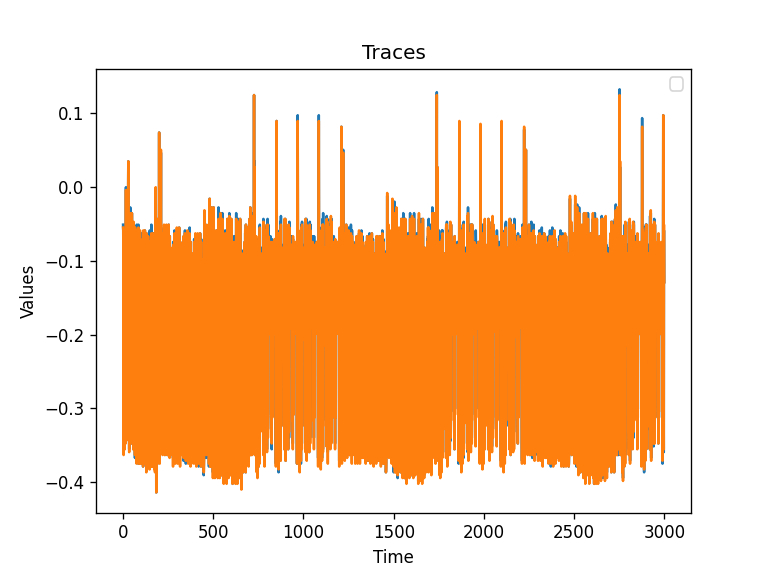

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


CWbytearray(b'2b 7e 15 16 28 ae d2 a6 ab f7 15 88 09 cf 4f 3c')


In [6]:
%matplotlib notebook
import matplotlib.pylab as plt

#print(trace_array[0])
#print(trace_array[1])
plt.figure()
plt.plot(trace_array[1])
plt.plot(trace_array[2999])
#plt.plot(trace_array[2])
#plt.plot(trace_array[4])
plt.xlabel("Time")
plt.ylabel("Values")
plt.title("Traces")
plt.legend()
plt.show()
print(key)

In [8]:
# ###################
# Add your code here
# ###################
#raise NotImplementedError("Add your code here, and delete this.")

# ###################
# START SOLUTION
# ###################
sbox = [
    # 0    1    2    3    4    5    6    7    8    9    a    b    c    d    e    f
    0x63,0x7c,0x77,0x7b,0xf2,0x6b,0x6f,0xc5,0x30,0x01,0x67,0x2b,0xfe,0xd7,0xab,0x76, # 0
    0xca,0x82,0xc9,0x7d,0xfa,0x59,0x47,0xf0,0xad,0xd4,0xa2,0xaf,0x9c,0xa4,0x72,0xc0, # 1
    0xb7,0xfd,0x93,0x26,0x36,0x3f,0xf7,0xcc,0x34,0xa5,0xe5,0xf1,0x71,0xd8,0x31,0x15, # 2
    0x04,0xc7,0x23,0xc3,0x18,0x96,0x05,0x9a,0x07,0x12,0x80,0xe2,0xeb,0x27,0xb2,0x75, # 3
    0x09,0x83,0x2c,0x1a,0x1b,0x6e,0x5a,0xa0,0x52,0x3b,0xd6,0xb3,0x29,0xe3,0x2f,0x84, # 4
    0x53,0xd1,0x00,0xed,0x20,0xfc,0xb1,0x5b,0x6a,0xcb,0xbe,0x39,0x4a,0x4c,0x58,0xcf, # 5
    0xd0,0xef,0xaa,0xfb,0x43,0x4d,0x33,0x85,0x45,0xf9,0x02,0x7f,0x50,0x3c,0x9f,0xa8, # 6
    0x51,0xa3,0x40,0x8f,0x92,0x9d,0x38,0xf5,0xbc,0xb6,0xda,0x21,0x10,0xff,0xf3,0xd2, # 7
    0xcd,0x0c,0x13,0xec,0x5f,0x97,0x44,0x17,0xc4,0xa7,0x7e,0x3d,0x64,0x5d,0x19,0x73, # 8
    0x60,0x81,0x4f,0xdc,0x22,0x2a,0x90,0x88,0x46,0xee,0xb8,0x14,0xde,0x5e,0x0b,0xdb, # 9
    0xe0,0x32,0x3a,0x0a,0x49,0x06,0x24,0x5c,0xc2,0xd3,0xac,0x62,0x91,0x95,0xe4,0x79, # a
    0xe7,0xc8,0x37,0x6d,0x8d,0xd5,0x4e,0xa9,0x6c,0x56,0xf4,0xea,0x65,0x7a,0xae,0x08, # b
    0xba,0x78,0x25,0x2e,0x1c,0xa6,0xb4,0xc6,0xe8,0xdd,0x74,0x1f,0x4b,0xbd,0x8b,0x8a, # c
    0x70,0x3e,0xb5,0x66,0x48,0x03,0xf6,0x0e,0x61,0x35,0x57,0xb9,0x86,0xc1,0x1d,0x9e, # d
    0xe1,0xf8,0x98,0x11,0x69,0xd9,0x8e,0x94,0x9b,0x1e,0x87,0xe9,0xce,0x55,0x28,0xdf, # e
    0x8c,0xa1,0x89,0x0d,0xbf,0xe6,0x42,0x68,0x41,0x99,0x2d,0x0f,0xb0,0x54,0xbb,0x16  # f
]

def aes_internal(inputdata, key):
    return sbox[inputdata ^ key]

HW = [bin(n).count("1") for n in range(0, 256)]
# ###################
# END SOLUTION
# ###################
assert HW[aes_internal(0xA1, 0x79)] == 3
assert HW[aes_internal(0x22, 0xB1)] == 5
print("✔️ OK to continue!")

# ###################
# Add your code here
# ###################
#raise NotImplementedError("Add your code here, and delete this.")

# ###################
# START SOLUTION
# ###################
def mean(X):
    return np.sum(X, axis=0)/len(X)

def std_dev(X, X_bar):
    return np.sqrt(np.sum((X-X_bar)**2, axis=0))

def cov(X, X_bar, Y, Y_bar):
    return np.sum((X-X_bar)*(Y-Y_bar), axis=0)
# ###################
# END SOLUTION
# ###################

✔️ OK to continue!


In [12]:
maxcpa = [0] * 256

# we don't need to redo the mean and std dev calculations
# for each key guess
t_bar = mean(trace_array)
o_t = std_dev(trace_array, t_bar)

for kguess in range(0, 256):
    hws = np.array([[HW[aes_internal(textin[5],kguess)] for textin in textin_array]]).transpose()

    # ###################
    # Add your code here
    # ###################
    #raise NotImplementedError("Add your code here, and delete this.")

    # ###################
    # START SOLUTION
    # ###################
    hws_bar = mean(hws)
    o_hws = std_dev(hws, hws_bar)
    correlation = cov(trace_array, t_bar, hws, hws_bar)
    cpaoutput = correlation/(o_t*o_hws)
    maxcpa[kguess] = max(abs(cpaoutput))


guess = np.argmax(maxcpa)
guess_corr = max(maxcpa)
# ###################
# END SOLUTION
# ###################
print("Key guess: ", hex(guess))
print("Correlation: ", guess_corr)

Key guess:  0xae
Correlation:  0.7258501887825413


In [11]:
t_bar = np.sum(trace_array, axis=0)/len(trace_array)
o_t = np.sqrt(np.sum((trace_array - t_bar)**2, axis=0))

cparefs = [0] * 16 #put your key byte guess correlations here
bestguess = [0] * 16 #put your key byte guesses here

for bnum in range(0, 16):
    maxcpa = [0] * 256
    for kguess in range(0, 256):
    # ###################
    # Add your code here
    # ###################
    #raise NotImplementedError("Add your code here, and delete this.")

    # ###################
    # START SOLUTION
    # ###################
        hws = np.array([[HW[aes_internal(textin[bnum],kguess)] for textin in textin_array]]).transpose()
        hws_bar = mean(hws)
        o_hws = std_dev(hws, hws_bar)
        correlation = cov(trace_array, t_bar, hws, hws_bar)
        cpaoutput = correlation/(o_t*o_hws)
        maxcpa[kguess] = max(abs(cpaoutput))
    bestguess[bnum] = np.argmax(maxcpa)
    cparefs[bnum] = max(maxcpa)
    # ###################
    # END SOLUTION
    # ###################

print("Best Key Guess: ", end="")
for b in bestguess: print("%02x " % b, end="")
print("\n", cparefs)

Best Key Guess: 2b 7e 15 16 28 ae d2 a6 ab f7 15 88 09 cf 4f 3c 
 [0.7427404931726939, 0.7448165494575796, 0.7410948099167699, 0.7284776012198, 0.7337590451075571, 0.7258501887825413, 0.7371041970377068, 0.72595545168779, 0.738131300720508, 0.7253725199446376, 0.7323092835395063, 0.7330033591009895, 0.7383136284462557, 0.7307952288831817, 0.7360646754680138, 0.7383361861835076]


In [13]:
numtraces = np.shape(trace_array)[0] #total number of traces
numpoints = np.shape(trace_array)[1] #samples per trace

# ###################
# Add your code here
# ###################
#raise NotImplementedError("Add Your Code Here")

# ###################
# START SOLUTION
# ##########guessed_byte#########
import numpy as np
mean_diffs = np.zeros(256)

guessed_byte = 0

for guess in range(0, 256):

    one_list = []
    zero_list = []

    numtraces = 20
    
    for trace_index in range(numtraces):

        #Get a hypothetical leakage list - use aes_internal(guess, input_byte)
        hypothetical_leakage = aes_internal(guess, textin_array[trace_index][guessed_byte])

        #Mask off the lowest bit - is it 0 or 1? Depending on that add trace to array
        if hypothetical_leakage & 0x01:
            one_list.append(trace_array[trace_index])
        else:
            zero_list.append(trace_array[trace_index])

    one_avg = np.asarray(one_list).mean(axis=0)
    zero_avg = np.asarray(zero_list).mean(axis=0)
    mean_diffs[guess] = np.max(abs(one_avg - zero_avg))

    print("Guessing %02x: %f"%(guess, mean_diffs[guess]))

maxdiff = max(mean_diffs)
indmax = np.argmax(mean_diffs)
#print(mean_diffs)

print("Best Key Guess: ", end="")
print("%02x, difference: %f" % (indmax, maxdiff), end="")
print("\n")
print("Real Key Guess: ", end="")
print("%02x, difference: %f" % (key[0], mean_diffs[[key[0]]]), end="")
print("\n")
print("Position: %d" % (mean_diffs>mean_diffs[[key[0]]]).sum())

# ###################
# END SOLUTION
# ###################

Guessing 00: 0.039418
Guessing 01: 0.029762
Guessing 02: 0.034643
Guessing 03: 0.029908
Guessing 04: 0.036296
Guessing 05: 0.033040
Guessing 06: 0.031250
Guessing 07: 0.036296
Guessing 08: 0.026953
Guessing 09: 0.038818
Guessing 0a: 0.028158
Guessing 0b: 0.041504
Guessing 0c: 0.030111
Guessing 0d: 0.023438
Guessing 0e: 0.027832
Guessing 0f: 0.025781
Guessing 10: 0.029948
Guessing 11: 0.028975
Guessing 12: 0.025228
Guessing 13: 0.025391
Guessing 14: 0.028760
Guessing 15: 0.031132
Guessing 16: 0.029147
Guessing 17: 0.035714
Guessing 18: 0.030859
Guessing 19: 0.027623
Guessing 1a: 0.030816
Guessing 1b: 0.029040
Guessing 1c: 0.029061
Guessing 1d: 0.035249
Guessing 1e: 0.026485
Guessing 1f: 0.032227
Guessing 20: 0.028764
Guessing 21: 0.027734
Guessing 22: 0.027734
Guessing 23: 0.028291
Guessing 24: 0.027541
Guessing 25: 0.035970
Guessing 26: 0.028291
Guessing 27: 0.032064
Guessing 28: 0.037891
Guessing 29: 0.029948
Guessing 2a: 0.025553
Guessing 2b: 0.042797
Guessing 2c: 0.033736
Guessing 2